In [1]:
import numpy as np
import pandas as pd
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
def correct_results( entry, column ):
    a = entry.loc[entry["kind"].str.startswith("actual")]
    n = entry.loc[entry["kind"].str.startswith("null")]
    n = n.groupby( ["siteA", "siteB", "date"] )[column].agg(
        null_upper=lambda x: x.quantile( 0.975 ),
        null_lower=lambda x: x.quantile( 0.025 ),
        null_median="median",
        null_mean="mean",
        null_std="std" )
    a = a.merge( n, left_on=["siteA", "siteB", "date"], right_index=True, validate="1:1" )
    a["corrected_sub"] = a["null_upper"] - a[column]
    a["corrected_z"] = (a["null_upper"] - a[column]) / a["null_std"]
    return a

In [ ]:
def load_results( loc, source, min_sequences = 0 ):
    """ Loads PhyloSor results from file.
    Parameters
    ----------
    loc : str
        Path to concatenated results files
    source : str
        Location to filter results to. Must be found in "siteA" column
    min_sequences : int
        Minimum number of genomes that both siteA and siteB must have for measurement to be included

    Returns
    -------
    pandas.DataFrame
        PhyloSor results
    """
    df = pd.read_csv( loc, parse_dates=["date"] )
    df = df.loc[df["siteA"]==source]
    df = df.loc[(df["countA"]>=min_sequences)&(df["countB"]>=min_sequences)]
    df["kind"] = df["kind"].fillna( "null" )
    df["kind"] = df["kind"] + df["num"].astype( str )
    df = df.drop( columns=["num"] )
    return df

res = load_results( "../resources/phylosor_newnull_results.csv", source="San Diego_CA", min_sequences=30 )

# Phylosor Norm

In [ ]:
def calculate_order( results, normalize=True ):
    return_df = results.loc[results["kind"]=="actual1"]
    return_df = return_df.pivot( index="siteB", columns="date", values="value" )
    if normalize:
        return_df = (return_df-return_df.min())/(return_df.max()-return_df.min())
    return return_df

orders = calculate_order( res )
orders = orders.reindex( index=orders.median( axis=1 ).sort_values( ascending=False ).index )

plot_df = orders.iloc[:20]
plot_mean = plot_df.median( axis=1 ).reset_index().reset_index()
plot_df = plot_df.melt( var_name="date", value_name="value", ignore_index=False ).reset_index()
plot_df = plot_df.merge( res.loc[res["kind"]=="actual1",["siteB","date", "countB"]], how="left" )
plot_df["count_sum"] = ">1000"
plot_df.loc[plot_df["countB"]<1000,"count_sum"] = "100-999"
plot_df.loc[plot_df["countB"]<100,"count_sum"] = "10-99"
plot_df.loc[plot_df["countB"]<10,"count_sum"] = "<10"

plot_df2 = orders.iloc[20:]
plot_mean2 = plot_df2.median( axis=1 ).reset_index().reset_index()
plot_df2 = plot_df2.melt( var_name="date", value_name="value", ignore_index=False ).reset_index()
plot_df2 = plot_df2.merge( res.loc[res["kind"]=="actual1",["siteB","date", "countB"]], how="left" )
plot_df2["count_sum"] = ">1000"
plot_df2.loc[plot_df2["countB"]<1000,"count_sum"] = "100-999"
plot_df2.loc[plot_df2["countB"]<100,"count_sum"] = "10-99"
plot_df2.loc[plot_df2["countB"]<10,"count_sum"] = "<10"

fig, ax = plt.subplots( dpi=200, figsize=(8,8), nrows=2, sharey=True )
hue_order = ["<10", "10-99", "100-999", ">1000"]
paletee = ["#E69F00", "#56B4E9", "#009E73", "#F0E442"]
sns.swarmplot( x="siteB", y="value", data=plot_df, size=3, ax=ax[0], hue="count_sum", hue_order=hue_order, palette=paletee )
sns.swarmplot( x="siteB", y="value", data=plot_df2, size=3, ax=ax[1], hue="count_sum", hue_order=hue_order, palette=paletee )
ax[0].hlines( plot_mean[0], xmin=plot_mean["index"]-0.25, xmax=plot_mean["index"]+0.25, color="black", linewidth=1, zorder=100 )
ax[1].hlines( plot_mean2[0], xmin=plot_mean2["index"]-0.25, xmax=plot_mean2["index"]+0.25, color="black", linewidth=1, zorder=100 )

ax[0].tick_params( axis="x", bottom=False, which="both", rotation=90, labelbottom=True, labelsize=8 )
ax[0].set_ylabel( "Normalized PhyloSor similarity" )
ax[0].set_xlabel( "" )
ax[0].set_title( f"Mean normalized PhyloSor" )
ax[0].grid( axis="y", zorder=1 )

ax[1].tick_params( axis="x", bottom=False, which="both", rotation=90, labelbottom=True, labelsize=8 )
ax[1].set_ylabel( "Normalized PhyloSor similarity" )
ax[1].set_xlabel( "" )
ax[1].set_xlim(ax[0].get_xlim())
ax[1].grid( axis="y", zorder=1, color="black" )
ax[1].get_legend().remove()

plt.tight_layout()
plt.savefig( f"phylosor_norm_sampling.pdf" )
plt.show()

In [ ]:
fig, ax = plt.subplots( dpi=200, figsize=(4,5) )
plot_df = orders.melt( var_name="date", value_name="value", ignore_index=False ).reset_index()
plot_df = plot_df.dropna()
plot_df = plot_df.merge( res.loc[res["kind"]=="actual1",["siteB","date", "countB"]], how="left" )
plot_df["count_sum"] = ">1000"
plot_df.loc[plot_df["countB"]<1000,"count_sum"] = "100-999"
plot_df.loc[plot_df["countB"]<100,"count_sum"] = "10-99"
plot_df.loc[plot_df["countB"]<10,"count_sum"] = "<10"
hue_order = ["<10", "10-99", "100-999", ">1000"]
paletee = ["#E69F00", "#56B4E9", "#009E73", "#F0E442"]
sns.swarmplot( x="count_sum", y="value", data=plot_df, size=3, order=hue_order, palette=paletee )
ax.grid( axis="y", zorder=1, color="black" )
ax.set_ylabel( "Normalized PhyloSor similarity" )
ax.set_xlabel( "Sequences" )
plt.tight_layout()
plt.savefig( "phylosor_sampling.pdf" )
plt.show()

In [ ]:
plot_df.head()

In [ ]:
from scipy.stats import kruskal, mannwhitneyu
#stat, p = kruskal(
#    plot_df.loc[plot_df["count_sum"]=="<10","value"].to_list(),
#    plot_df.loc[plot_df["count_sum"]=="10-99","value"].to_list(),
#    plot_df.loc[plot_df["count_sum"]=="100-999","value"].to_list(),
#    plot_df.loc[plot_df["count_sum"]==">1000","value"].to_list()
#)

seqs = ["<10", "10-99", "100-999", ">1000"]
for i, value in enumerate( seqs ):
    for value2 in seqs[i:]:
        if value != value2:
            print( value, value2 )
            print( mannwhitneyu( plot_df.loc[plot_df["count_sum"]==value,"value"], plot_df.loc[plot_df["count_sum"]==value2,"value"] ) )

# Temporal similarity

In [ ]:
plot_df = res.loc[(res["kind"]=="actual1")&(res["siteB"].isin( orders.index[:5]))]

fig, ax = plt.subplots( dpi=200, figsize=(10,4) )
for name, entry in plot_df.groupby( "siteB" ):
    ax.plot( "date", "value", data=entry, label=name, zorder=100 )
ax.legend(loc="upper left")
ax.xaxis.set_major_locator( mdates.YearLocator() )
ax.xaxis.set_major_formatter( mdates.DateFormatter( "%b %Y" ))
ax.xaxis.set_minor_locator( mdates.MonthLocator() )
ax.xaxis.set_minor_formatter( mdates.DateFormatter( "%b" ))
ax.tick_params( axis="x", which="both", rotation=90 )
ax.set_xlim( ( pd.to_datetime("2020-01-01"), pd.to_datetime("2022-01-01") ) )
ax.set_ylim( 0, 0.6 )
ax.set_ylabel( "Proportion of\nbranch lengths shared")
ax.grid( axis="y", zorder=0 )
plt.tight_layout()
plt.savefig( "top_phylosor.pdf" )
plt.show()

In [ ]:
plot_df = res.loc[(res["kind"]=="actual1")&(res["siteB"].isin( orders.index[-5:]))]

fig, ax = plt.subplots( dpi=200, figsize=(10,4) )
for name, entry in plot_df.groupby( "siteB" ):
    ax.plot( "date", "value", data=entry, label=name, zorder=100 )
ax.legend(loc="upper left")
ax.xaxis.set_major_locator( mdates.YearLocator() )
ax.xaxis.set_major_formatter( mdates.DateFormatter( "%b %Y" ))
ax.xaxis.set_minor_locator( mdates.MonthLocator() )
ax.xaxis.set_minor_formatter( mdates.DateFormatter( "%b" ))
ax.tick_params( axis="x", which="both", rotation=90 )
ax.set_xlim( ( pd.to_datetime("2020-01-01"), pd.to_datetime("2022-01-01") ) )
ax.set_ylim( 0, 0.6 )
ax.set_ylabel( "Proportion of\nbranch lengths shared")
ax.grid( axis="y", zorder=0 )
plt.tight_layout()
plt.savefig( "bottom_phylosor.pdf" )
plt.show()

In [ ]:
first_wave = ["2020-03-01", "2020-04-01", "2020-05-01", "2020-06-01", "2020-07-01", "2020-08-01"] # ("2020-01-01","2020-08-15")
second_wave = ( "2020-11-01", "2021-03-02" )
third_wave = ( "2021-07-01", "2022-03-02" )

# Sampling-depended rankings

In [ ]:
medians = []
ranks = []
counts = []

test_values = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

for count in test_values:
    res = load_results( loc="../resources/phylosor_newnull_results.csv", source="San Diego_CA", min_sequences=count )
    orders = calculate_order( res )
    median = orders.median( axis=1 )
    median.name = count
    rank = median.rank( ascending=False )
    rank.name = count
    nonna = orders.count( axis=1 )
    nonna.name = count

    medians.append( median )
    ranks.append( rank )
    counts.append( nonna )

medians = pd.concat( medians, axis=1, ignore_index=False )
plot_order = medians[1].sort_values().index
medians_corr = medians.corr()
medians = medians.melt( var_name="min_sequences", value_name="median_value", ignore_index=False ).reset_index()
ranks = pd.concat( ranks, axis=1, ignore_index=False )
ranks = ranks.melt( var_name="min_sequences", value_name="rank", ignore_index=False ).reset_index()
counts = pd.concat( counts, axis=1, ignore_index=False )
counts = counts.melt( var_name="min_sequences", value_name="nonnull_months", ignore_index=False ).reset_index()

plot_df = medians.merge( counts ).merge( ranks )
plot_df.head()

In [ ]:
fig, ax = plt.subplots( dpi=200, figsize=(7,10) )
sns.lineplot( x="min_sequences", y="rank", hue="siteB", data=plot_df, hue_order=plot_order, zorder=100, ax=ax )
sns.scatterplot( x="min_sequences", y="rank", hue="siteB", data=plot_df, s=75, hue_order=plot_order, zorder=101, ax=ax, linewidth=1)

for _, i in plot_df.iterrows():
    ax.text( x=i["min_sequences"], y=i["rank"], s=f'{i["nonnull_months"]:.0f}', zorder=105, ha="center", va="center", fontsize=4 )

ax.set_xticks( test_values )
ax.set_xlim( 0, test_values[-1]+2 )
ax.set_yticks( range(1, len( plot_order ) + 1 ) )
ax.set_yticklabels( reversed( plot_order ) )
ax.set_ylabel( "" )
ax.set_ylim( 0.5, len( plot_order ) + 0.5 )
ax.legend().remove()
ax.grid( axis="x", zorder=1 )
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots( dpi=200, figsize=(7,10) )
sns.lineplot( x="min_sequences", y="median_value", hue="siteB", data=plot_df, hue_order=plot_order, zorder=100 )
ax.set_xticks( test_values )
ax.set_xlim( 0, test_values[-1] )
ax.legend().remove()
ax.grid( axis="x", zorder=1 )
plt.tight_layout()
plt.show()

# Mean difference to mixed model

In [ ]:
cor.loc[cor.index.isin( orders.index[:5] )]

In [ ]:
correct_results( res, "value" ).sort_values("null_std", ascending=False )

In [ ]:
cor = correct_results( res, "value" )
fig, ax = plt.subplots( dpi=200, figsize=(10,12), nrows=5, sharey=True, sharex=True )
for i, loc in enumerate( orders.index[-5:] ):
    ax[i].fill_between( "date", "null_upper", "null_lower", data=cor.loc[cor["siteB"]==loc], color='black', alpha=0.1, zorder=90, linewidth=0, label="shuffled locations" )
    ax[i].plot( "date", "value", data=cor.loc[cor["siteB"]==loc], color="black", label=loc, zorder=100 )
    ax[i].legend( loc="upper left" )
    ax[i].set_ylim( 0, 0.6 )
    ax[i].set_ylabel( "Proportion of\nbranch lengths shared" )
    ax[i].grid( axis="both", which="both", zorder=0 )

ax[4].xaxis.set_major_locator( mdates.YearLocator() )
ax[4].xaxis.set_major_formatter( mdates.DateFormatter( "%b %Y" ))
ax[4].xaxis.set_minor_locator( mdates.MonthLocator() )
ax[4].xaxis.set_minor_formatter( mdates.DateFormatter( "%b" ))
ax[4].tick_params( axis="x", which="both", rotation=90 )
ax[4].set_xlim( pd.to_datetime( "2020-01-01" ), pd.to_datetime( "2022-01-01" ) )
plt.tight_layout()
#plt.savefig( "phylosor_top_null.pdf" )
plt.show()

In [ ]:
plot_df = correct_results( res, "value" ).query( "siteB=='Manitoba'")
fig, ax = plt.subplots( dpi=200, figsize=(10,3) )
ax.fill_between( "date", "null_upper", "null_lower", data=plot_df, color='black', alpha=0.1, zorder=2, linewidth=0 )
ax.plot( "date", "value", data=plot_df, color="black")
plt.tight_layout()
plt.show()

In [ ]:
plot_df = correct_results( res, "value" ).query( "siteB=='Baja California'")
fig, ax = plt.subplots( dpi=200, figsize=(10,3) )
ax.fill_between( "date", "null_upper", "null_lower", data=plot_df, color='black', alpha=0.1, zorder=2, linewidth=0 )
ax.plot( "date", "value", data=plot_df, color="black")
plt.tight_layout()
plt.show()

In [ ]:
plot_df = correct_results( res, "value" ).query( "siteB=='Alameda_CA'")
fig, ax = plt.subplots( dpi=200, figsize=(10,3) )
ax.fill_between( "date", "null_upper", "null_lower", data=plot_df, color='black', alpha=0.1, zorder=2, linewidth=0 )
ax.plot( "date", "value", data=plot_df, color="black" )
plt.tight_layout()
plt.show()

In [ ]:
correct_results( res, "value" ).query( "siteB=='Baja California'")

In [ ]:
cor = correct_results( res, "value" )
cor = cor.pivot( index="siteB", columns="date", values="corrected_z" )
plot_bottom = cor.loc[cor.index.isin( orders.index[-5:] )]
median_bot = plot_bottom.median( axis=1 ).reset_index().reset_index()
plot_bottom = plot_bottom.melt( var_name="date", value_name="value", ignore_index=False ).reset_index()

plot_top = cor.loc[cor.index.isin( orders.index[:5] )]
median_top = plot_top.median( axis=1 ).reset_index().reset_index()
plot_top = plot_top.melt( var_name="date", value_name="value", ignore_index=False ).reset_index()

fig, ax = plt.subplots( dpi=200, figsize=(8,4), ncols=2, sharey=True )
sns.swarmplot( x="siteB", y="value", data=plot_top, size=3, ax=ax[0] )
ax[0].hlines( median_top[0], xmin=median_top["index"]-0.25, xmax=median_top["index"]+0.25, color="black", linewidth=1, zorder=100 )
sns.swarmplot( x="siteB", y="value", data=plot_bottom, size=3, ax=ax[1] )
ax[1].hlines( median_bot[0], xmin=median_bot["index"]-0.25, xmax=median_bot["index"]+0.25, color="black", linewidth=1, zorder=100 )

ax[0].tick_params( axis="x", which="both", rotation=90 )
ax[1].tick_params( axis="x", which="both", rotation=90 )
ax[0].set_xlabel( "" )
ax[1].set_xlabel( "" )
ax[0].set_title( "Top 5 locations" )
ax[1].set_title( "Bottom 5 locations" )
ax[0].grid( axis="y", zorder=0 )
ax[1].grid( axis="y", zorder=0 )

ax[0].set_ylabel( "Distance to mixed model (Z-score)" )
ax[1].label_outer()

plt.tight_layout()
#plt.savefig( "phylosor_mixing_z_all.pdf" )
plt.show()

In [ ]:
plot_df = correct_results( res, "value" ).query( "siteB=='Manitoba'")
fig, ax = plt.subplots( dpi=200, figsize=(10,3) )
ax.fill_between( "date", "null_upper", "null_lower", data=plot_df, color='black', alpha=0.1, zorder=2, linewidth=0 )
ax.plot( "date", "value", data=plot_df, color="black")
plt.tight_layout()
plt.show()

In [ ]:
plot_df = correct_results( res, "value" ).query( "siteB=='Baja California'")
fig, ax = plt.subplots( dpi=200, figsize=(10,3) )
ax.fill_between( "date", "null_upper", "null_lower", data=plot_df, color='black', alpha=0.1, zorder=2, linewidth=0 )
ax.plot( "date", "value", data=plot_df, color="black")
plt.tight_layout()
plt.show()

In [ ]:
plot_df = correct_results( res, "value" ).query( "siteB=='Alameda_CA'")
fig, ax = plt.subplots( dpi=200, figsize=(10,3) )
ax.fill_between( "date", "null_upper", "null_lower", data=plot_df, color='black', alpha=0.1, zorder=2, linewidth=0 )
ax.plot( "date", "value", data=plot_df, color="black" )
plt.tight_layout()
plt.show()

In [ ]:
correct_results( res, "value" ).query( "siteB=='Baja California'")

In [ ]:
cor = correct_results( res, "value" )
cor = cor.pivot( index="siteB", columns="date", values="corrected_z" )
plot_bottom = cor.loc[cor.index.isin( orders.index[-5:] )]
median_bot = plot_bottom.median( axis=1 ).reset_index().reset_index()
plot_bottom = plot_bottom.melt( var_name="date", value_name="value", ignore_index=False ).reset_index()

plot_top = cor.loc[cor.index.isin( orders.index[:5] )]
median_top = plot_top.median( axis=1 ).reset_index().reset_index()
plot_top = plot_top.melt( var_name="date", value_name="value", ignore_index=False ).reset_index()

fig, ax = plt.subplots( dpi=200, figsize=(8,4), ncols=2, sharey=True )
sns.swarmplot( x="siteB", y="value", data=plot_top, size=3, ax=ax[0] )
ax[0].hlines( median_top[0], xmin=median_top["index"]-0.25, xmax=median_top["index"]+0.25, color="black", linewidth=1, zorder=100 )
sns.swarmplot( x="siteB", y="value", data=plot_bottom, size=3, ax=ax[1] )
ax[1].hlines( median_bot[0], xmin=median_bot["index"]-0.25, xmax=median_bot["index"]+0.25, color="black", linewidth=1, zorder=100 )

ax[0].tick_params( axis="x", which="both", rotation=90 )
ax[1].tick_params( axis="x", which="both", rotation=90 )
ax[0].set_xlabel( "" )
ax[1].set_xlabel( "" )
ax[0].set_title( "Top 5 locations" )
ax[1].set_title( "Bottom 5 locations" )
ax[0].grid( axis="y", zorder=0 )
ax[1].grid( axis="y", zorder=0 )

ax[0].set_ylabel( "Distance to mixed model (Z-score)" )
ax[1].label_outer()

plt.tight_layout()
#plt.savefig( "phylosor_mixing_z_all.pdf" )
plt.show()

In [ ]:
def correct_results( entry, column ):
    a = entry.loc[entry["kind"].str.startswith("actual")]
    n = entry.loc[entry["kind"].str.startswith("null")]
    n = n.groupby( ["siteA", "siteB", "date"] )[column].agg(
        null_upper=lambda x: x.quantile( 0.975 ),
        null_lower=lambda x: x.quantile( 0.025 ),
        null_median="median",
        null_mean="mean",
        null_std="std" )
    a = a.merge( n, left_on=["siteA", "siteB", "date"], right_index=True, validate="1:1" )
    a["corrected_sub"] = a["null_upper"] - a[column]
    a["corrected_z"] = (a["null_upper"] - a[column]) / a["null_std"]
    return a

In [ ]:
cor = correct_results( res, "value" )
cor = cor.pivot( index="siteB", columns="date", values="corrected_z" )

cor = cor.reindex(index=cor.median(axis=1).sort_values( ascending=True ).index)

plot_df = cor.iloc[:20]
plot_mean = plot_df.median( axis=1 ).reset_index().reset_index()
plot_df = plot_df.melt( var_name="date", value_name="value", ignore_index=False ).reset_index()
#
plot_df2 = cor.iloc[20:]
plot_mean2 = plot_df2.median( axis=1 ).reset_index().reset_index()
plot_df2 = plot_df2.melt( var_name="date", value_name="value", ignore_index=False ).reset_index()
#
fig, ax = plt.subplots( dpi=200, figsize=(8,8), nrows=2, sharey=True )
sns.swarmplot( x="siteB", y="value", data=plot_df, size=3, ax=ax[0], color="#56B4E9" )
sns.swarmplot( x="siteB", y="value", data=plot_df2, size=3, ax=ax[1], color="#56B4E9" )
ax[0].hlines( plot_mean[0], xmin=plot_mean["index"]-0.25, xmax=plot_mean["index"]+0.25, color="black", linewidth=1, zorder=100 )
ax[1].hlines( plot_mean2[0], xmin=plot_mean2["index"]-0.25, xmax=plot_mean2["index"]+0.25, color="black", linewidth=1, zorder=100 )

ax[0].tick_params( axis="x", bottom=False, which="both", rotation=90, labelbottom=True, labelsize=8 )
ax[0].set_ylabel( "Distance to mixed model (Z-score)" )
ax[0].set_xlabel( "" )
#ax[0].set_title( f"Mean normalized PhyloSor" )
ax[0].grid( axis="y", zorder=1 )

ax[1].tick_params( axis="x", bottom=False, which="both", rotation=90, labelbottom=True, labelsize=8 )
ax[1].set_ylabel( "Distance to mixed model (Z-score)" )
ax[1].set_xlabel( "" )
ax[1].grid( axis="y", zorder=1 )

plt.tight_layout()
#plt.savefig( f"mixed_phylosor_all.pdf" )
plt.show()

In [ ]:
raw = res.loc[res["kind"]=="actual1"]
raw = raw.pivot( index="siteB", columns="date", values="value" )
orders = raw.rank( ascending=False )
orders = orders.reindex(index=orders.median(axis=1).sort_values().index)
phylosor_order = orders.median( axis=1 )

cor = correct_results( res, "value" )
cor = cor.pivot( index="siteB", columns="date", values="corrected_sub" )
null_order = cor.median( axis=1 )

plot_df = pd.concat( [phylosor_order, null_order], ignore_index=False, axis=1 )
plot_df.columns = ["phylosor_rank", "mixing"]

fig, ax = plt.subplots( dpi=200, figsize=(5,4) )
ax.scatter( "phylosor_rank", "mixing", data=plot_df )
plt.tight_layout()
plt.show()

# Hill stuff

In [ ]:
min_sequences = 0
hill = pd.read_csv( "../resources/hill_results.csv", parse_dates=["date"] )
hill = hill.loc[hill["siteA"]=="San Diego_CA"]
hill = hill.loc[(hill["countA"]>min_sequences)&(hill["countB"]>min_sequences)]
hill["kind"] = hill["kind"].fillna( "null" )
hill["kind"] = hill["kind"] + hill["num"].astype( str )
hill = hill.drop( columns=["num"] )
hill.head()

In [ ]:
raw = hill.loc[hill["kind"]=="actual1"]
raw = raw.pivot( index="siteB", columns="date", values="local_similarity" )
raw = raw.reindex(index=raw.median(axis=1).sort_values( ascending=False ).index)

orders = (raw-raw.min())/(raw.max()-raw.min())
orders = orders.reindex( index=orders.median( axis=1 ).sort_values( ascending=False ).index )

plot_df = orders.iloc[:20]
plot_mean = plot_df.median( axis=1 ).reset_index().reset_index()
plot_df = plot_df.melt( var_name="date", value_name="value", ignore_index=False ).reset_index()

plot_df2 = orders.iloc[20:]
plot_mean2 = plot_df2.median( axis=1 ).reset_index().reset_index()
plot_df2 = plot_df2.melt( var_name="date", value_name="value", ignore_index=False ).reset_index()

fig, ax = plt.subplots( dpi=200, figsize=(8,8), nrows=2, sharey=True )
sns.swarmplot( x="siteB", y="value", data=plot_df, size=3, ax=ax[0], color="blue" )
sns.swarmplot( x="siteB", y="value", data=plot_df2, size=3, ax=ax[1], color="blue" )
ax[0].hlines( plot_mean[0], xmin=plot_mean["index"]-0.25, xmax=plot_mean["index"]+0.25, color="black", linewidth=1, zorder=100 )
ax[1].hlines( plot_mean2[0], xmin=plot_mean2["index"]-0.25, xmax=plot_mean2["index"]+0.25, color="black", linewidth=1, zorder=100 )

ax[0].tick_params( axis="x", bottom=False, which="both", rotation=90, labelbottom=True, labelsize=8 )
ax[0].set_ylabel( "Normalized Hill similarity" )
ax[0].set_xlabel( "" )
ax[0].set_title( f"Mean normalized PhyloSor" )
ax[0].grid( axis="y", zorder=1 )

ax[1].tick_params( axis="x", bottom=False, which="both", rotation=90, labelbottom=True, labelsize=8 )
ax[1].set_ylabel( "Normalized Hill similarity" )
ax[1].set_xlabel( "" )
ax[1].grid( axis="y", zorder=1, color="black" )

plt.tight_layout()
plt.show()

In [ ]:
raw = hill.loc[hill["kind"]=="actual1"]
raw = raw.pivot( index="siteB", columns="date", values="local_similarity" )
raw = raw.reindex(index=raw.median(axis=1).sort_values( ascending=False ).index)

orders = (raw-raw.min())/(raw.max()-raw.min())
orders = orders.reindex( index=orders.median( axis=1 ).sort_values( ascending=False ).index )

plot_df = orders.iloc[:20]
plot_mean = plot_df.median( axis=1 ).reset_index().reset_index()
plot_df = plot_df.melt( var_name="date", value_name="value", ignore_index=False ).reset_index()
plot_df = plot_df.merge( hill.loc[hill["kind"]=="actual1",["siteB","date", "countB"]], how="left" )
plot_df["count_sum"] = ">1000"
plot_df.loc[plot_df["countB"]<1000,"count_sum"] = "100-999"
plot_df.loc[plot_df["countB"]<100,"count_sum"] = "10-99"
plot_df.loc[plot_df["countB"]<10,"count_sum"] = "<10"

plot_df2 = orders.iloc[20:]
plot_mean2 = plot_df2.median( axis=1 ).reset_index().reset_index()
plot_df2 = plot_df2.melt( var_name="date", value_name="value", ignore_index=False ).reset_index()
plot_df2 = plot_df2.merge( hill.loc[hill["kind"]=="actual1",["siteB","date", "countB"]], how="left" )
plot_df2["count_sum"] = ">1000"
plot_df2.loc[plot_df2["countB"]<1000,"count_sum"] = "100-999"
plot_df2.loc[plot_df2["countB"]<100,"count_sum"] = "10-99"
plot_df2.loc[plot_df2["countB"]<10,"count_sum"] = "<10"

fig, ax = plt.subplots( dpi=200, figsize=(8,8), nrows=2, sharey=True )
hue_order = ["<10", "10-99", "100-999", ">1000"]
paletee = ["#E69F00", "#56B4E9", "#009E73", "#F0E442"]
sns.swarmplot( x="siteB", y="value", data=plot_df, size=3, ax=ax[0], hue="count_sum", hue_order=hue_order, palette=paletee )
sns.swarmplot( x="siteB", y="value", data=plot_df2, size=3, ax=ax[1], hue="count_sum", hue_order=hue_order, palette=paletee )
ax[0].hlines( plot_mean[0], xmin=plot_mean["index"]-0.25, xmax=plot_mean["index"]+0.25, color="black", linewidth=1, zorder=100 )
ax[1].hlines( plot_mean2[0], xmin=plot_mean2["index"]-0.25, xmax=plot_mean2["index"]+0.25, color="black", linewidth=1, zorder=100 )

ax[0].tick_params( axis="x", bottom=False, which="both", rotation=90, labelbottom=True, labelsize=8 )
ax[0].set_ylabel( "Normalized Hill similarity" )
ax[0].set_xlabel( "" )
ax[0].set_title( f"Median normalized Hill similarity" )
ax[0].grid( axis="y", zorder=1 )

ax[1].tick_params( axis="x", bottom=False, which="both", rotation=90, labelbottom=True, labelsize=8 )
ax[1].set_ylabel( "Normalized Hill similarity" )
ax[1].set_xlabel( "" )
ax[1].grid( axis="y", zorder=1, color="black" )

plt.tight_layout()
plt.savefig( "hill_norm_sampling.pdf" )
plt.show()

plot_df["count_sum"] = ">1000"
plot_df.loc[plot_df["countB"]<1000,"count_sum"] = "100-999"
plot_df.loc[plot_df["countB"]<100,"count_sum"] = "10-99"
plot_df.loc[plot_df["countB"]<10,"count_sum"] = "<10"

In [ ]:
fig, ax = plt.subplots( dpi=200, figsize=(4,5) )
plot_df = orders.melt( var_name="date", value_name="value", ignore_index=False ).reset_index()
plot_df = plot_df.dropna()
plot_df = plot_df.merge( hill.loc[hill["kind"]=="actual1",["siteB","date", "countB"]], how="left" )
plot_df["count_sum"] = ">1000"
plot_df.loc[plot_df["countB"]<1000,"count_sum"] = "100-999"
plot_df.loc[plot_df["countB"]<100,"count_sum"] = "10-99"
plot_df.loc[plot_df["countB"]<10,"count_sum"] = "<10"
hue_order = ["<10", "10-99", "100-999", ">1000"]
paletee = ["#E69F00", "#56B4E9", "#009E73", "#F0E442"]
sns.swarmplot( x="count_sum", y="value", data=plot_df, size=3, order=hue_order, palette=paletee )
ax.grid( axis="y", zorder=1, color="black" )
ax.set_ylabel( "Normalized Hill similarity" )
ax.set_xlabel( "Sequences" )
plt.tight_layout()
plt.savefig( "hill_sampling.pdf" )
plt.show()

In [ ]:
from scipy.stats import kruskal, mannwhitneyu


seqs = ["<10", "10-99", "100-999", ">1000"]
for i, value in enumerate( seqs ):
    for value2 in seqs[i:]:
        if value != value2:
            print( value, value2 )
            print( mannwhitneyu( plot_df.loc[plot_df["count_sum"]==value,"value"], plot_df.loc[plot_df["count_sum"]==value2,"value"] ) )

In [ ]:
plot_df = hill.loc[(hill["kind"]=="actual1")&(hill["siteB"].isin( orders.index[:5]))]

fig, ax = plt.subplots( dpi=200, figsize=(10,4) )
for name, entry in plot_df.groupby( "siteB" ):
    ax.plot( "date", "local_similarity", data=entry, label=name, zorder=100 )
ax.legend(loc="upper left")
ax.xaxis.set_major_locator( mdates.YearLocator() )
ax.xaxis.set_major_formatter( mdates.DateFormatter( "%b %Y" ))
ax.xaxis.set_minor_locator( mdates.MonthLocator() )
ax.xaxis.set_minor_formatter( mdates.DateFormatter( "%b" ))
ax.tick_params( axis="x", which="both", rotation=90 )
ax.set_xlim( ( pd.to_datetime("2020-01-01"), pd.to_datetime("2022-01-01") ) )
ax.set_ylim( 0, 1 )
ax.set_ylabel( "Local similarity")
ax.grid( axis="y", zorder=0 )
plt.tight_layout()
plt.savefig( "top_hill.pdf" )
plt.show()

In [ ]:
plot_df = hill.loc[(hill["kind"]=="actual1")&(hill["siteB"].isin( orders.index[-5:]))]

fig, ax = plt.subplots( dpi=200, figsize=(10,4) )
for name, entry in plot_df.groupby( "siteB" ):
    ax.plot( "date", "local_similarity", data=entry, label=name, zorder=100 )
ax.legend(loc="upper left")
ax.xaxis.set_major_locator( mdates.YearLocator() )
ax.xaxis.set_major_formatter( mdates.DateFormatter( "%b %Y" ))
ax.xaxis.set_minor_locator( mdates.MonthLocator() )
ax.xaxis.set_minor_formatter( mdates.DateFormatter( "%b" ))
ax.tick_params( axis="x", which="both", rotation=90 )
ax.set_xlim( ( pd.to_datetime("2020-01-01"), pd.to_datetime("2022-01-01") ) )
ax.set_ylim( 0, 1 )
ax.set_ylabel( "Local similarity")
ax.grid( axis="y", zorder=0 )
plt.tight_layout()
plt.savefig( "bottom_hill.pdf" )
plt.show()

In [ ]:
cor = correct_results( hill, "local_similarity" )
cor = cor.pivot( index="siteB", columns="date", values="corrected_z" )
cor = cor.drop(columns=pd.to_datetime( "2021-12-01" ) )
cor = cor.reindex(index=cor.median(axis=1).sort_values( ascending=True ).index)


In [ ]:
cor = correct_results( hill, "local_similarity" )
cor = cor.pivot( index="siteB", columns="date", values="corrected_z" )
cor = cor.drop(columns=pd.to_datetime( "2021-12-01" ) )
cor = cor.reindex(index=cor.median(axis=1).sort_values( ascending=True ).index)

plot_df = cor.iloc[:20]
plot_mean = plot_df.median( axis=1 ).reset_index().reset_index()
plot_df = plot_df.melt( var_name="date", value_name="value", ignore_index=False ).reset_index()
#
plot_df2 = cor.iloc[20:]
plot_mean2 = plot_df2.median( axis=1 ).reset_index().reset_index()
plot_df2 = plot_df2.melt( var_name="date", value_name="value", ignore_index=False ).reset_index()


fig, ax = plt.subplots( dpi=200, figsize=(8,8), nrows=2, sharey=True )
sns.swarmplot( x="siteB", y="value", data=plot_df, size=3, ax=ax[0], color="#56B4E9" )
sns.swarmplot( x="siteB", y="value", data=plot_df2, size=3, ax=ax[1], color="#56B4E9" )
ax[0].hlines( plot_mean[0], xmin=plot_mean["index"]-0.25, xmax=plot_mean["index"]+0.25, color="black", linewidth=1, zorder=100 )
ax[1].hlines( plot_mean2[0], xmin=plot_mean2["index"]-0.25, xmax=plot_mean2["index"]+0.25, color="black", linewidth=1, zorder=100 )

ax[0].tick_params( axis="x", bottom=False, which="both", rotation=90, labelbottom=True, labelsize=8 )
ax[0].set_ylabel( "Distance to mixed model (Z-score)" )
ax[0].set_xlabel( "" )
#ax[0].set_title( f"Mean normalized PhyloSor" )
ax[0].grid( axis="y", zorder=1 )

ax[1].tick_params( axis="x", bottom=False, which="both", rotation=90, labelbottom=True, labelsize=8 )
ax[1].set_ylabel( "Distance to mixed model (Z-score)" )
ax[1].set_xlabel( "" )
ax[1].grid( axis="y", zorder=1 )
ax[1].set_ylim(0,100)

plt.tight_layout()
#plt.savefig( f"mixed_phylosor_all.pdf" )
plt.show()

In [ ]:
# Is there concordence between PhyloSor and Hill

raw = hill.loc[hill["kind"]=="actual1"]
raw = raw.pivot( index="siteB", columns="date", values="local_similarity" )
hill_ranks = raw.median(axis=1).sort_values( ascending=False ).reset_index().reset_index()
hill_ranks.columns = ["hill_rank","siteB", "median_hill"]

raw = res.loc[res["kind"]=="actual1"]
raw = raw.pivot( index="siteB", columns="date", values="value" )
phylosor_ranks = raw.median(axis=1).sort_values( ascending=False ).reset_index().reset_index()
phylosor_ranks.columns = ["phylosor_rank", "siteB", "median_phylosor"]

comparison = hill_ranks.merge( phylosor_ranks )
comparison
#
#from scipy.stats import kendalltau
#kendalltau( hill_ranks, phylosor_ranks )

In [ ]:
comparison.plot( x="median_phylosor", y="median_hill", kind="scatter" )

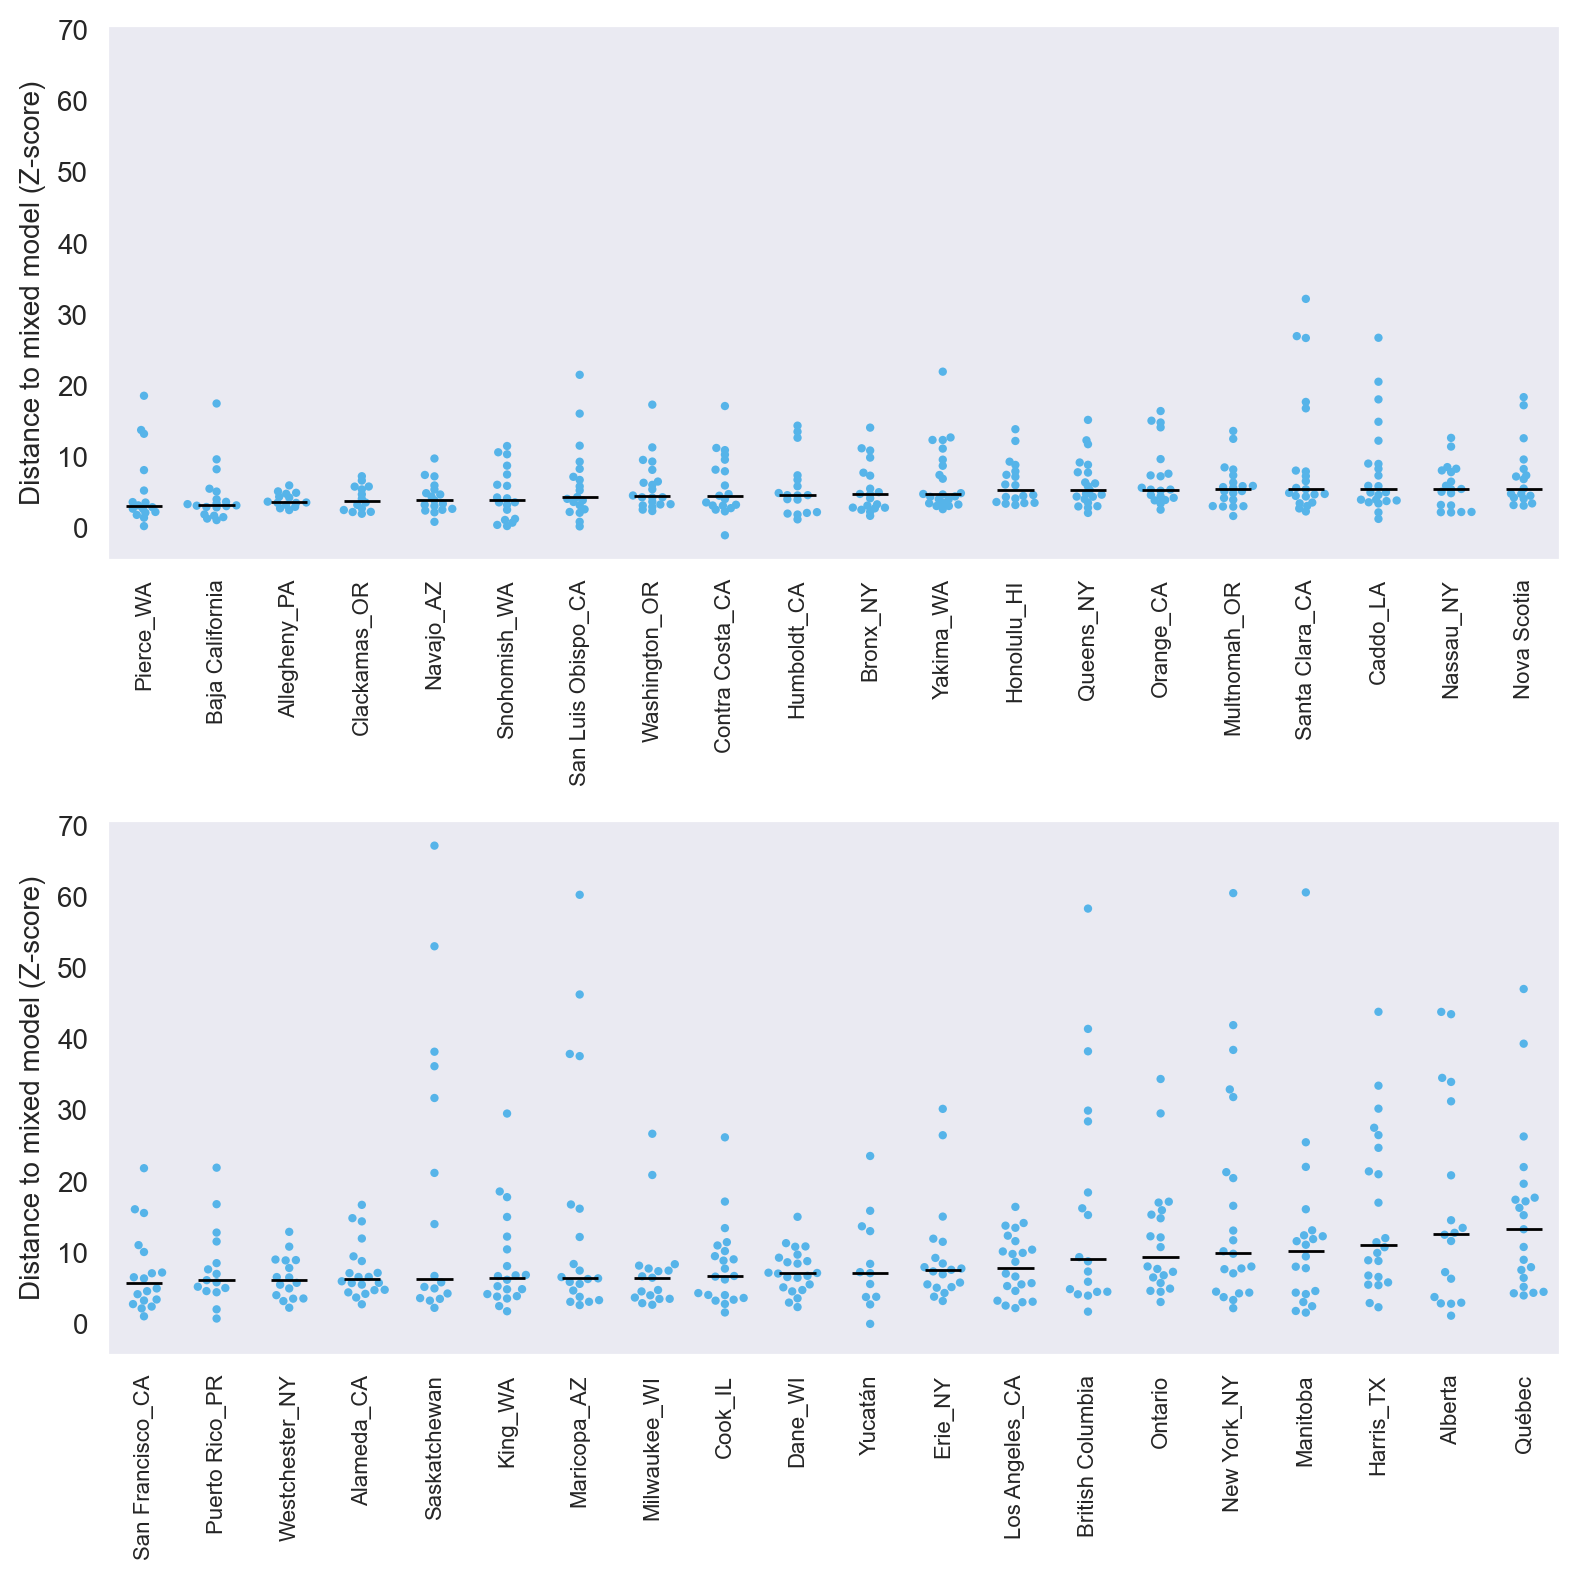

In [18]:
cor = correct_results( res, "value" )
cor = cor.pivot( index="siteB", columns="date", values="corrected_z" )

cor = cor.reindex(index=cor.median(axis=1).sort_values( ascending=True ).index)

plot_df = cor.iloc[:20]
plot_mean = plot_df.median( axis=1 ).reset_index().reset_index()
plot_df = plot_df.melt( var_name="date", value_name="value", ignore_index=False ).reset_index()
#
plot_df2 = cor.iloc[20:]
plot_mean2 = plot_df2.median( axis=1 ).reset_index().reset_index()
plot_df2 = plot_df2.melt( var_name="date", value_name="value", ignore_index=False ).reset_index()
#
fig, ax = plt.subplots( dpi=200, figsize=(8,8), nrows=2, sharey=True )
sns.swarmplot( x="siteB", y="value", data=plot_df, size=3, ax=ax[0], color="#56B4E9" )
sns.swarmplot( x="siteB", y="value", data=plot_df2, size=3, ax=ax[1], color="#56B4E9" )
ax[0].hlines( plot_mean[0], xmin=plot_mean["index"]-0.25, xmax=plot_mean["index"]+0.25, color="black", linewidth=1, zorder=100 )
ax[1].hlines( plot_mean2[0], xmin=plot_mean2["index"]-0.25, xmax=plot_mean2["index"]+0.25, color="black", linewidth=1, zorder=100 )

ax[0].tick_params( axis="x", bottom=False, which="both", rotation=90, labelbottom=True, labelsize=8 )
ax[0].set_ylabel( "Distance to mixed model (Z-score)" )
ax[0].set_xlabel( "" )
#ax[0].set_title( f"Mean normalized PhyloSor" )
ax[0].grid( axis="y", zorder=1 )

ax[1].tick_params( axis="x", bottom=False, which="both", rotation=90, labelbottom=True, labelsize=8 )
ax[1].set_ylabel( "Distance to mixed model (Z-score)" )
ax[1].set_xlabel( "" )
ax[1].grid( axis="y", zorder=1 )

plt.tight_layout()
#plt.savefig( f"mixed_phylosor_all.pdf" )
plt.show()

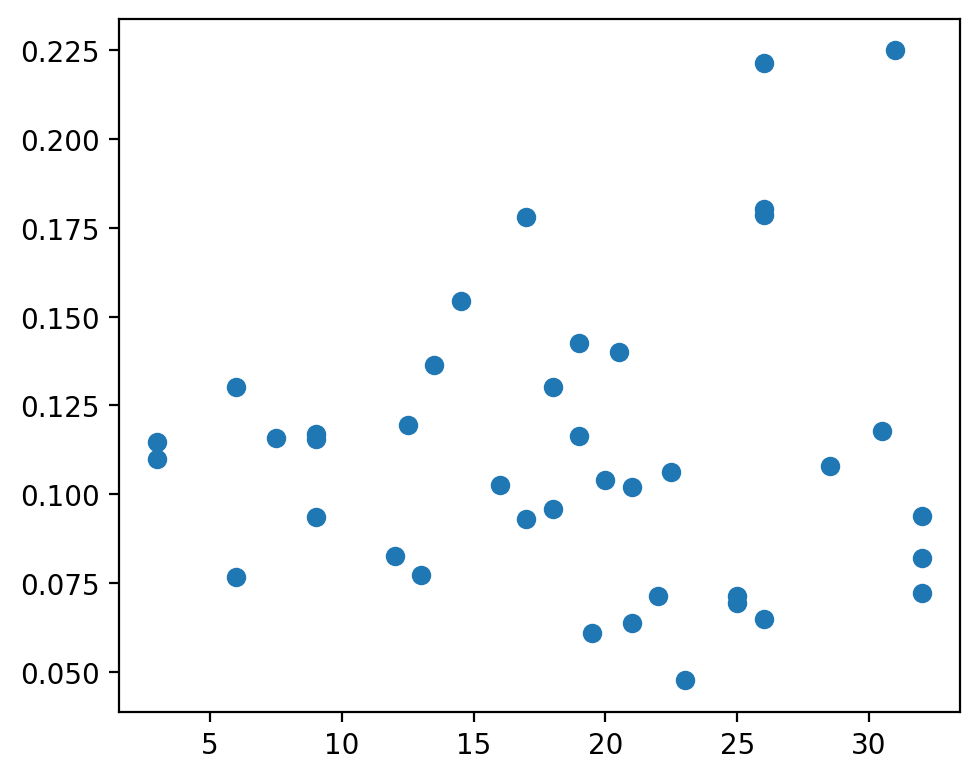

In [12]:
raw = res.loc[res["kind"]=="actual1"]
raw = raw.pivot( index="siteB", columns="date", values="value" )
orders = raw.rank( ascending=False )
orders = orders.reindex(index=orders.median(axis=1).sort_values().index)
phylosor_order = orders.median( axis=1 )

cor = correct_results( res, "value" )
cor = cor.pivot( index="siteB", columns="date", values="corrected_sub" )
null_order = cor.median( axis=1 )

plot_df = pd.concat( [phylosor_order, null_order], ignore_index=False, axis=1 )
plot_df.columns = ["phylosor_rank", "mixing"]

fig, ax = plt.subplots( dpi=200, figsize=(5,4) )
ax.scatter( "phylosor_rank", "mixing", data=plot_df )
plt.tight_layout()
plt.show()

# Hill stuff

In [3]:
min_sequences = 0
hill = pd.read_csv( "../resources/hill_results.csv", parse_dates=["date"] )
hill = hill.loc[hill["siteA"]=="San Diego_CA"]
hill = hill.loc[(hill["countA"]>min_sequences)&(hill["countB"]>min_sequences)]
hill["kind"] = hill["kind"].fillna( "null" )
hill["kind"] = hill["kind"] + hill["num"].astype( str )
hill = hill.drop( columns=["num"] )
hill.head()

,q,gamma_pd,alpha_pd,beta_pd,local_similarity,region_similarity,date,siteA,countA,siteB,countB,kind
0,1,0.000091,0.000085,1.065041,0.909091,0.909091,2019-12-01,San Diego_CA,6,British Columbia,5,null1
1,1,0.000150,0.000127,1.178945,0.762503,0.762503,2020-01-01,San Diego_CA,3,British Columbia,7,null1
2,1,0.001115,0.000928,1.201744,0.734870,0.734870,2020-03-01,San Diego_CA,11,British Columbia,25,null1
3,1,0.001351,0.001155,1.169826,0.773706,0.773706,2020-04-01,San Diego_CA,14,British Columbia,32,null1
4,1,0.002501,0.002080,1.202618,0.733821,0.733821,2020-05-01,San Diego_CA,34,British Columbia,69,null1


/usr/local/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 27.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


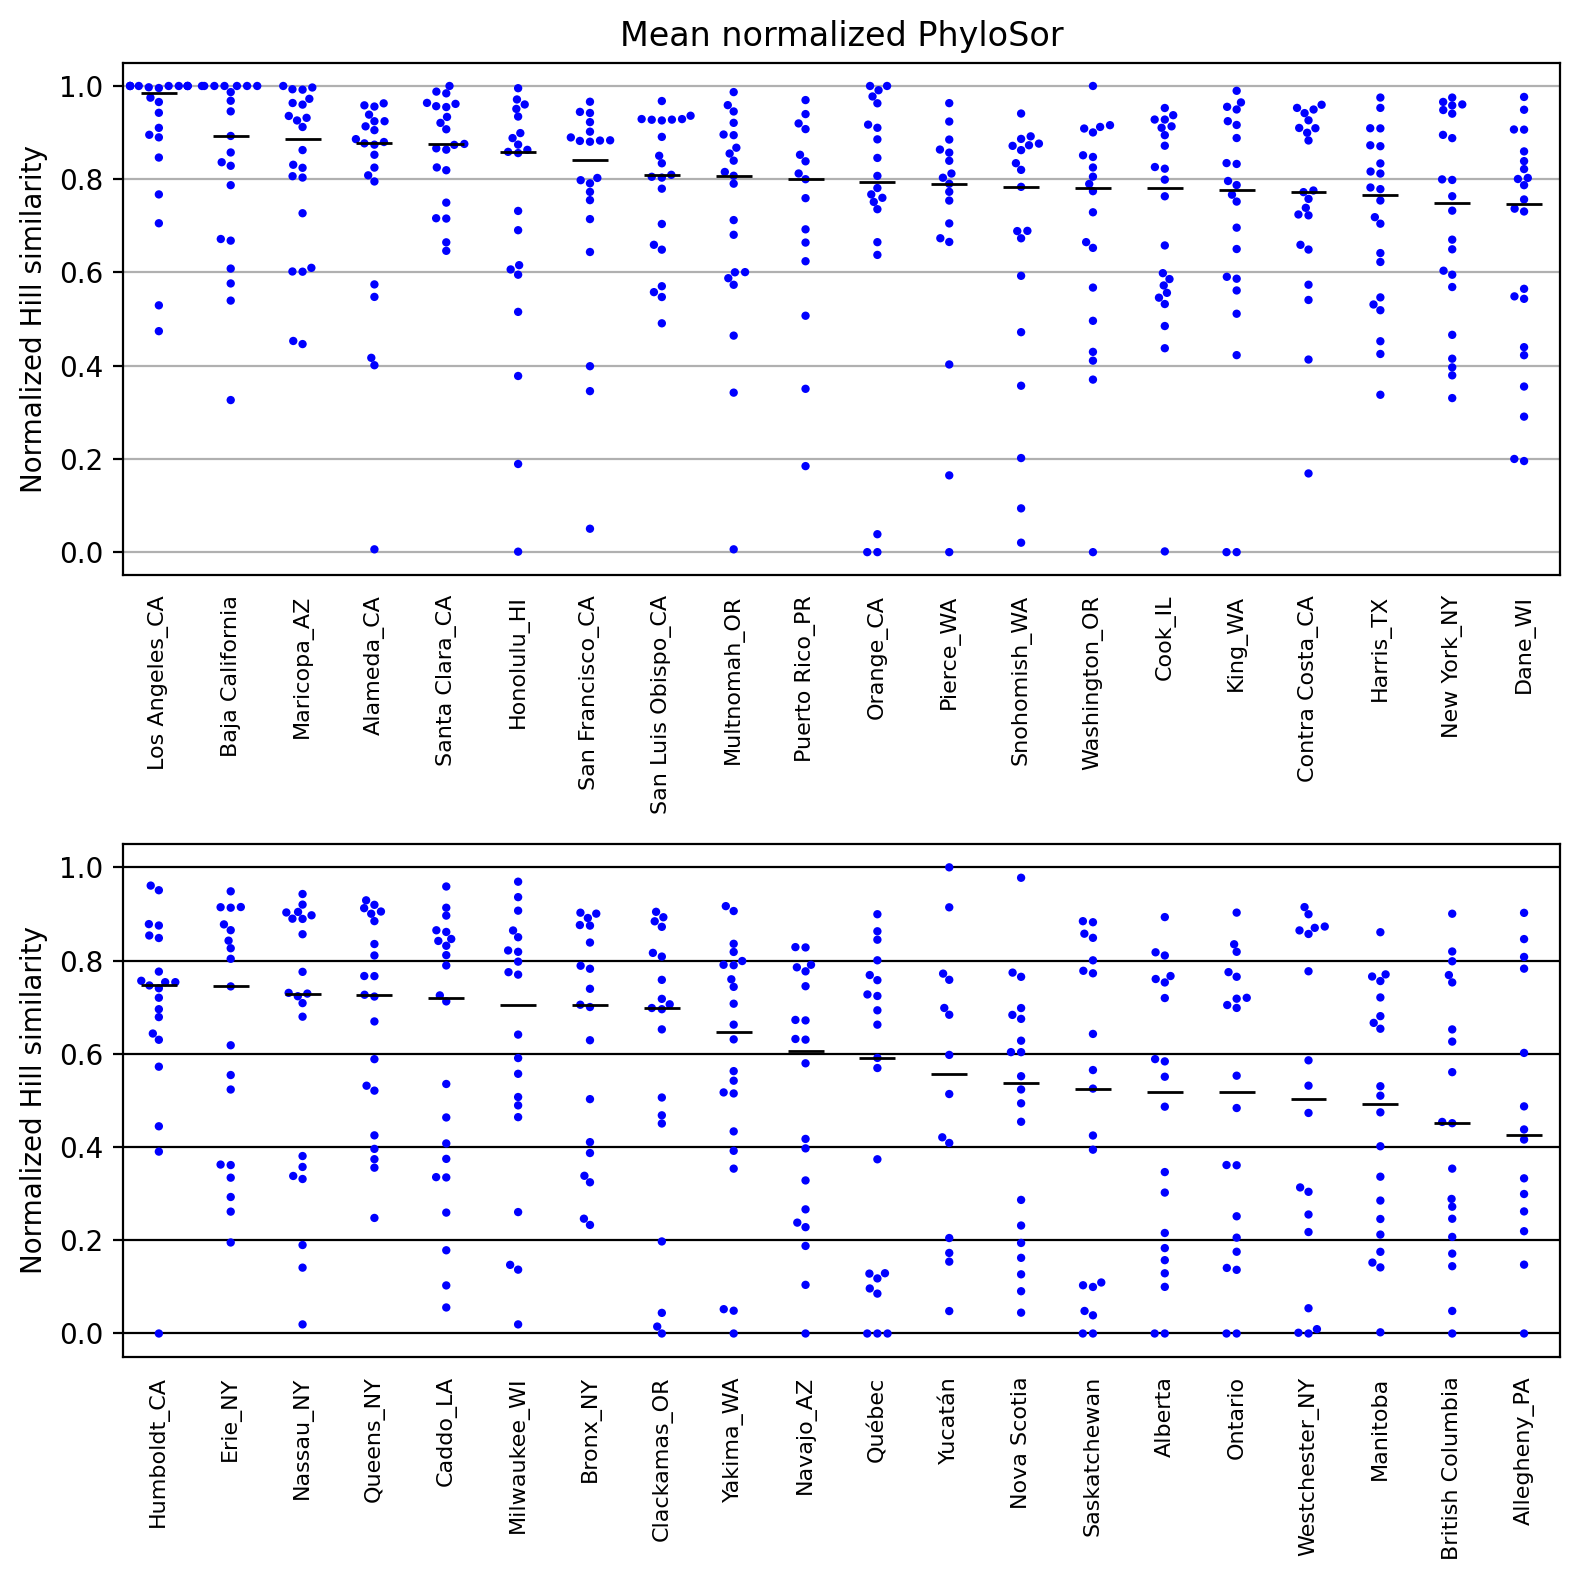

In [4]:
raw = hill.loc[hill["kind"]=="actual1"]
raw = raw.pivot( index="siteB", columns="date", values="local_similarity" )
raw = raw.reindex(index=raw.median(axis=1).sort_values( ascending=False ).index)

orders = (raw-raw.min())/(raw.max()-raw.min())
orders = orders.reindex( index=orders.median( axis=1 ).sort_values( ascending=False ).index )

plot_df = orders.iloc[:20]
plot_mean = plot_df.median( axis=1 ).reset_index().reset_index()
plot_df = plot_df.melt( var_name="date", value_name="value", ignore_index=False ).reset_index()

plot_df2 = orders.iloc[20:]
plot_mean2 = plot_df2.median( axis=1 ).reset_index().reset_index()
plot_df2 = plot_df2.melt( var_name="date", value_name="value", ignore_index=False ).reset_index()

fig, ax = plt.subplots( dpi=200, figsize=(8,8), nrows=2, sharey=True )
sns.swarmplot( x="siteB", y="value", data=plot_df, size=3, ax=ax[0], color="blue" )
sns.swarmplot( x="siteB", y="value", data=plot_df2, size=3, ax=ax[1], color="blue" )
ax[0].hlines( plot_mean[0], xmin=plot_mean["index"]-0.25, xmax=plot_mean["index"]+0.25, color="black", linewidth=1, zorder=100 )
ax[1].hlines( plot_mean2[0], xmin=plot_mean2["index"]-0.25, xmax=plot_mean2["index"]+0.25, color="black", linewidth=1, zorder=100 )

ax[0].tick_params( axis="x", bottom=False, which="both", rotation=90, labelbottom=True, labelsize=8 )
ax[0].set_ylabel( "Normalized Hill similarity" )
ax[0].set_xlabel( "" )
ax[0].set_title( f"Mean normalized PhyloSor" )
ax[0].grid( axis="y", zorder=1 )

ax[1].tick_params( axis="x", bottom=False, which="both", rotation=90, labelbottom=True, labelsize=8 )
ax[1].set_ylabel( "Normalized Hill similarity" )
ax[1].set_xlabel( "" )
ax[1].grid( axis="y", zorder=1, color="black" )

plt.tight_layout()
plt.show()

/usr/local/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 27.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


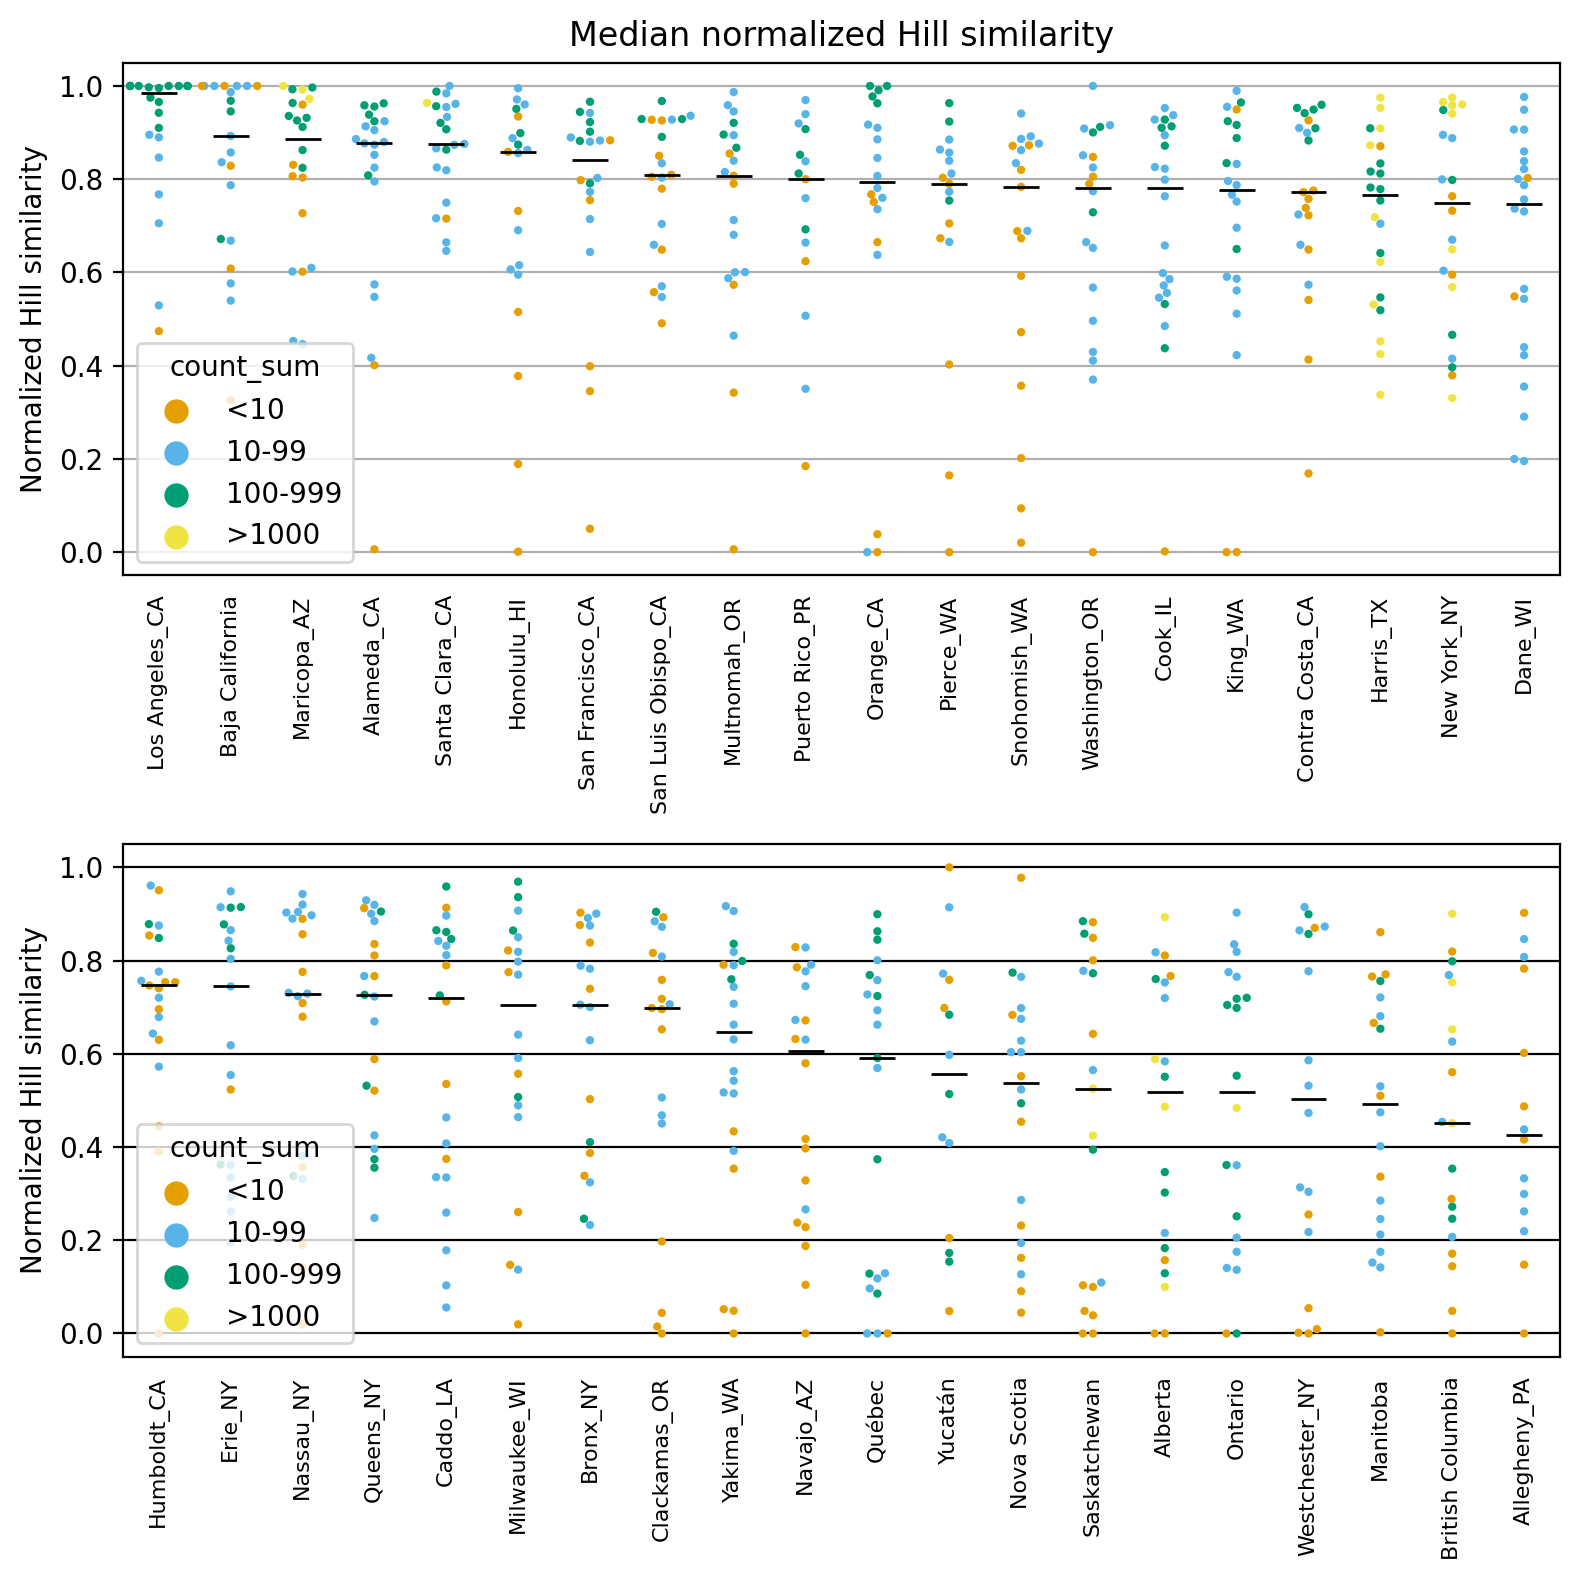

In [7]:
raw = hill.loc[hill["kind"]=="actual1"]
raw = raw.pivot( index="siteB", columns="date", values="local_similarity" )
raw = raw.reindex(index=raw.median(axis=1).sort_values( ascending=False ).index)

orders = (raw-raw.min())/(raw.max()-raw.min())
orders = orders.reindex( index=orders.median( axis=1 ).sort_values( ascending=False ).index )

plot_df = orders.iloc[:20]
plot_mean = plot_df.median( axis=1 ).reset_index().reset_index()
plot_df = plot_df.melt( var_name="date", value_name="value", ignore_index=False ).reset_index()
plot_df = plot_df.merge( hill.loc[hill["kind"]=="actual1",["siteB","date", "countB"]], how="left" )
plot_df["count_sum"] = ">1000"
plot_df.loc[plot_df["countB"]<1000,"count_sum"] = "100-999"
plot_df.loc[plot_df["countB"]<100,"count_sum"] = "10-99"
plot_df.loc[plot_df["countB"]<10,"count_sum"] = "<10"

plot_df2 = orders.iloc[20:]
plot_mean2 = plot_df2.median( axis=1 ).reset_index().reset_index()
plot_df2 = plot_df2.melt( var_name="date", value_name="value", ignore_index=False ).reset_index()
plot_df2 = plot_df2.merge( hill.loc[hill["kind"]=="actual1",["siteB","date", "countB"]], how="left" )
plot_df2["count_sum"] = ">1000"
plot_df2.loc[plot_df2["countB"]<1000,"count_sum"] = "100-999"
plot_df2.loc[plot_df2["countB"]<100,"count_sum"] = "10-99"
plot_df2.loc[plot_df2["countB"]<10,"count_sum"] = "<10"

fig, ax = plt.subplots( dpi=200, figsize=(8,8), nrows=2, sharey=True )
hue_order = ["<10", "10-99", "100-999", ">1000"]
paletee = ["#E69F00", "#56B4E9", "#009E73", "#F0E442"]
sns.swarmplot( x="siteB", y="value", data=plot_df, size=3, ax=ax[0], hue="count_sum", hue_order=hue_order, palette=paletee )
sns.swarmplot( x="siteB", y="value", data=plot_df2, size=3, ax=ax[1], hue="count_sum", hue_order=hue_order, palette=paletee )
ax[0].hlines( plot_mean[0], xmin=plot_mean["index"]-0.25, xmax=plot_mean["index"]+0.25, color="black", linewidth=1, zorder=100 )
ax[1].hlines( plot_mean2[0], xmin=plot_mean2["index"]-0.25, xmax=plot_mean2["index"]+0.25, color="black", linewidth=1, zorder=100 )

ax[0].tick_params( axis="x", bottom=False, which="both", rotation=90, labelbottom=True, labelsize=8 )
ax[0].set_ylabel( "Normalized Hill similarity" )
ax[0].set_xlabel( "" )
ax[0].set_title( f"Median normalized Hill similarity" )
ax[0].grid( axis="y", zorder=1 )

ax[1].tick_params( axis="x", bottom=False, which="both", rotation=90, labelbottom=True, labelsize=8 )
ax[1].set_ylabel( "Normalized Hill similarity" )
ax[1].set_xlabel( "" )
ax[1].grid( axis="y", zorder=1, color="black" )

plt.tight_layout()
plt.savefig( "hill_norm_sampling.pdf" )
plt.show()

plot_df["count_sum"] = ">1000"
plot_df.loc[plot_df["countB"]<1000,"count_sum"] = "100-999"
plot_df.loc[plot_df["countB"]<100,"count_sum"] = "10-99"
plot_df.loc[plot_df["countB"]<10,"count_sum"] = "<10"

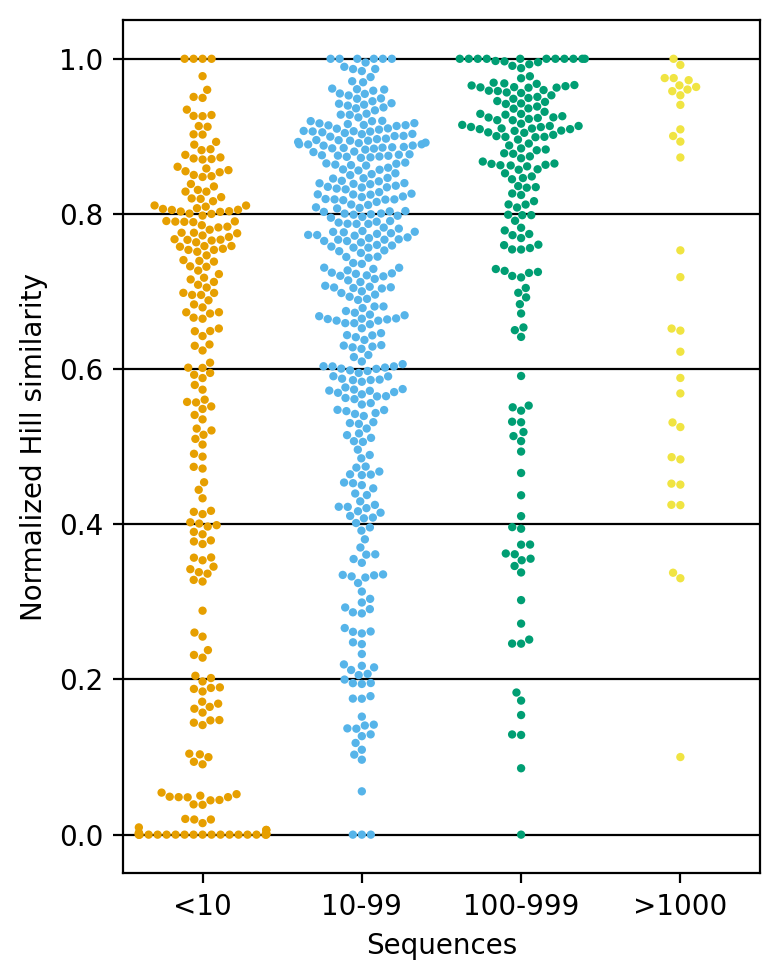

In [8]:
fig, ax = plt.subplots( dpi=200, figsize=(4,5) )
plot_df = orders.melt( var_name="date", value_name="value", ignore_index=False ).reset_index()
plot_df = plot_df.dropna()
plot_df = plot_df.merge( hill.loc[hill["kind"]=="actual1",["siteB","date", "countB"]], how="left" )
plot_df["count_sum"] = ">1000"
plot_df.loc[plot_df["countB"]<1000,"count_sum"] = "100-999"
plot_df.loc[plot_df["countB"]<100,"count_sum"] = "10-99"
plot_df.loc[plot_df["countB"]<10,"count_sum"] = "<10"
hue_order = ["<10", "10-99", "100-999", ">1000"]
paletee = ["#E69F00", "#56B4E9", "#009E73", "#F0E442"]
sns.swarmplot( x="count_sum", y="value", data=plot_df, size=3, order=hue_order, palette=paletee )
ax.grid( axis="y", zorder=1, color="black" )
ax.set_ylabel( "Normalized Hill similarity" )
ax.set_xlabel( "Sequences" )
plt.tight_layout()
plt.savefig( "hill_sampling.pdf" )
plt.show()

In [34]:
from scipy.stats import kruskal, mannwhitneyu


seqs = ["<10", "10-99", "100-999", ">1000"]
for i, value in enumerate( seqs ):
    for value2 in seqs[i:]:
        if value != value2:
            print( value, value2 )
            print( mannwhitneyu( plot_df.loc[plot_df["count_sum"]==value,"value"], plot_df.loc[plot_df["count_sum"]==value2,"value"] ) )

<10 10-99
MannwhitneyuResult(statistic=30226.0, pvalue=7.367090875225553e-09)
<10 100-999
MannwhitneyuResult(statistic=9106.0, pvalue=1.4249728384856631e-19)
<10 >1000
MannwhitneyuResult(statistic=2443.0, pvalue=0.001139402344183214)
10-99 100-999
MannwhitneyuResult(statistic=21241.5, pvalue=1.6888989018908188e-09)
10-99 >1000
MannwhitneyuResult(statistic=5351.0, pvalue=0.24912035172245528)
100-999 >1000
MannwhitneyuResult(statistic=3120.5, pvalue=0.30767383675871907)


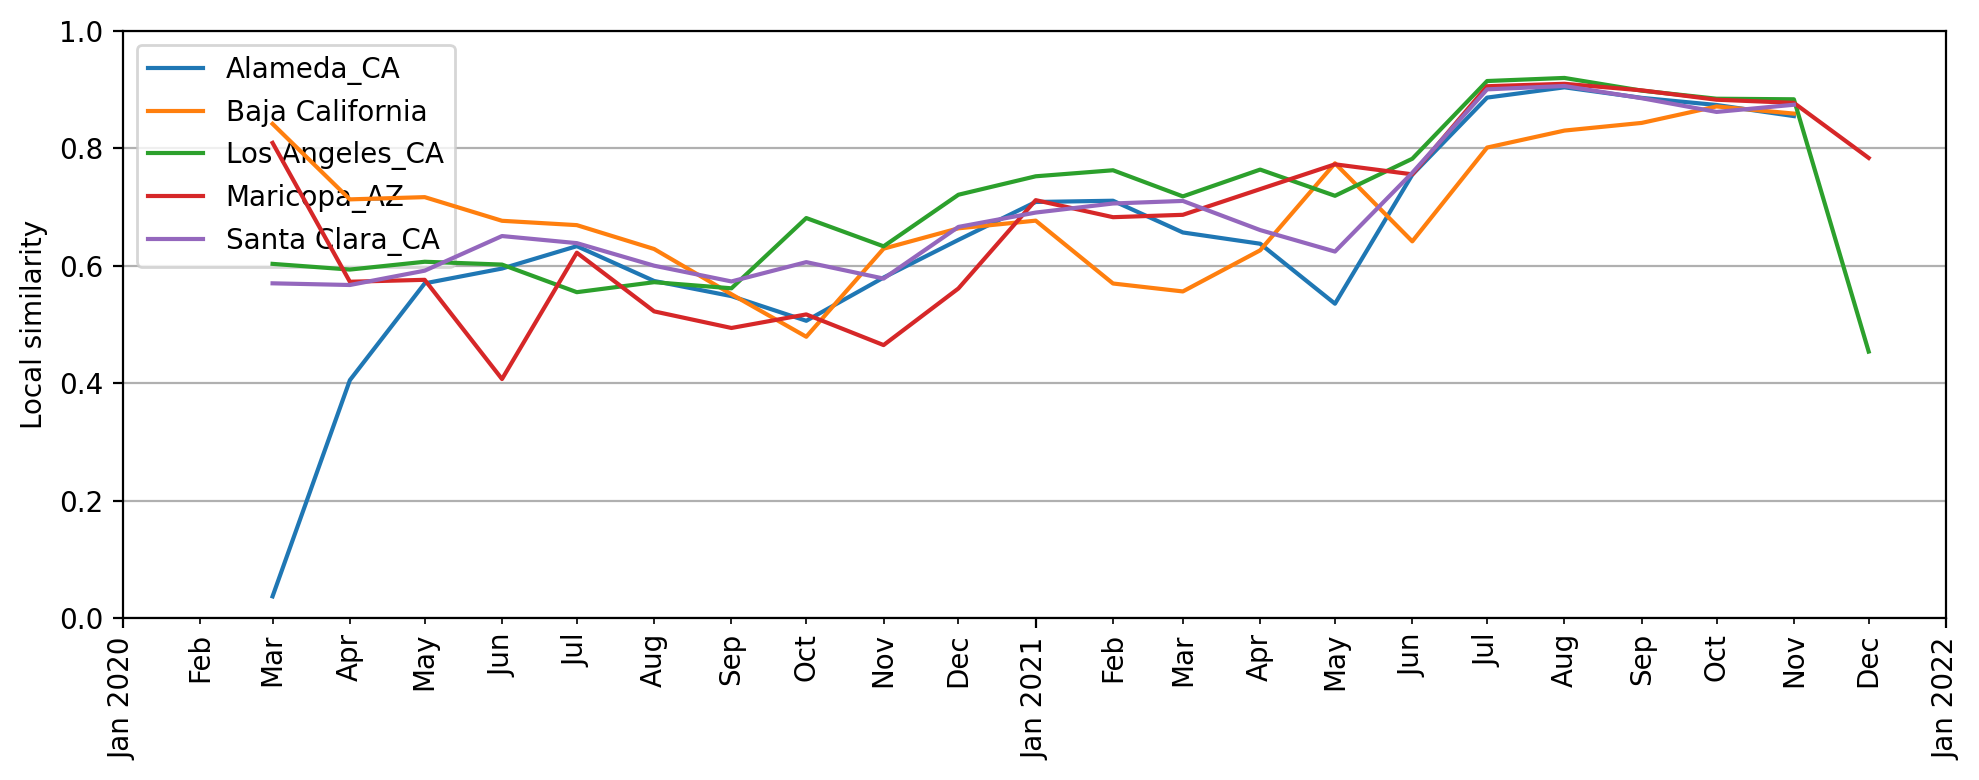

In [22]:
plot_df = hill.loc[(hill["kind"]=="actual1")&(hill["siteB"].isin( orders.index[:5]))]

fig, ax = plt.subplots( dpi=200, figsize=(10,4) )
for name, entry in plot_df.groupby( "siteB" ):
    ax.plot( "date", "local_similarity", data=entry, label=name, zorder=100 )
ax.legend(loc="upper left")
ax.xaxis.set_major_locator( mdates.YearLocator() )
ax.xaxis.set_major_formatter( mdates.DateFormatter( "%b %Y" ))
ax.xaxis.set_minor_locator( mdates.MonthLocator() )
ax.xaxis.set_minor_formatter( mdates.DateFormatter( "%b" ))
ax.tick_params( axis="x", which="both", rotation=90 )
ax.set_xlim( ( pd.to_datetime("2020-01-01"), pd.to_datetime("2022-01-01") ) )
ax.set_ylim( 0, 1 )
ax.set_ylabel( "Local similarity")
ax.grid( axis="y", zorder=0 )
plt.tight_layout()
plt.savefig( "top_hill.pdf" )
plt.show()

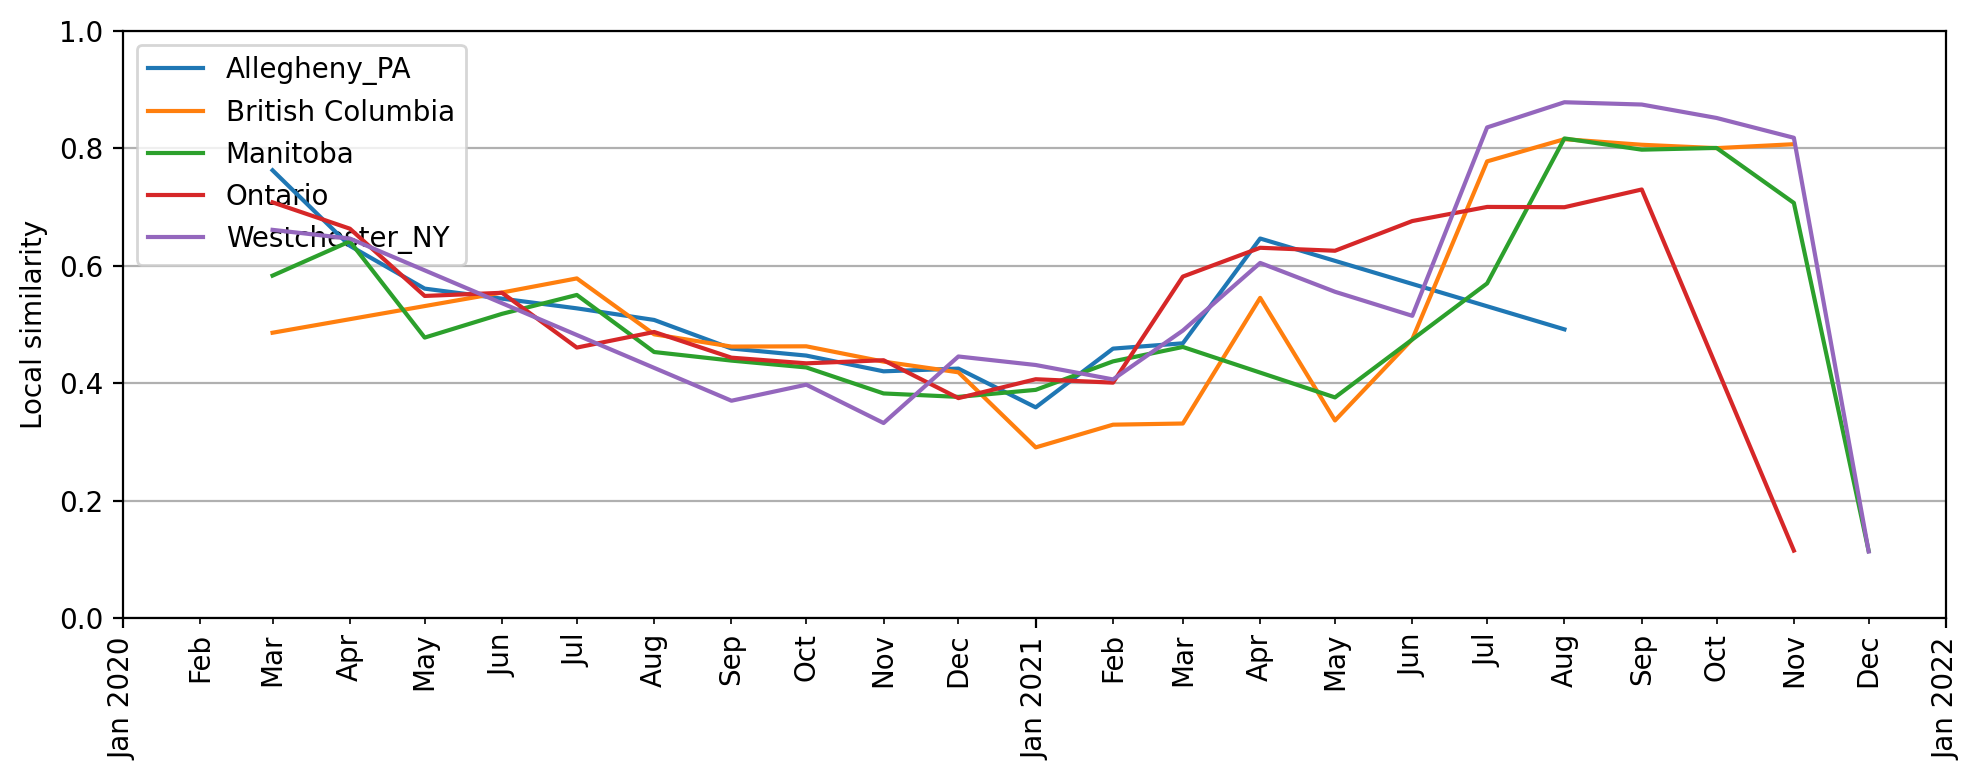

In [23]:
plot_df = hill.loc[(hill["kind"]=="actual1")&(hill["siteB"].isin( orders.index[-5:]))]

fig, ax = plt.subplots( dpi=200, figsize=(10,4) )
for name, entry in plot_df.groupby( "siteB" ):
    ax.plot( "date", "local_similarity", data=entry, label=name, zorder=100 )
ax.legend(loc="upper left")
ax.xaxis.set_major_locator( mdates.YearLocator() )
ax.xaxis.set_major_formatter( mdates.DateFormatter( "%b %Y" ))
ax.xaxis.set_minor_locator( mdates.MonthLocator() )
ax.xaxis.set_minor_formatter( mdates.DateFormatter( "%b" ))
ax.tick_params( axis="x", which="both", rotation=90 )
ax.set_xlim( ( pd.to_datetime("2020-01-01"), pd.to_datetime("2022-01-01") ) )
ax.set_ylim( 0, 1 )
ax.set_ylabel( "Local similarity")
ax.grid( axis="y", zorder=0 )
plt.tight_layout()
plt.savefig( "bottom_hill.pdf" )
plt.show()

In [17]:
cor = correct_results( hill, "local_similarity" )
cor = cor.pivot( index="siteB", columns="date", values="corrected_z" )
cor = cor.drop(columns=pd.to_datetime( "2021-12-01" ) )
cor = cor.reindex(index=cor.median(axis=1).sort_values( ascending=True ).index)


/usr/local/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 42.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 28.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 19.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 23.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 38.1% of the points cannot be placed; y

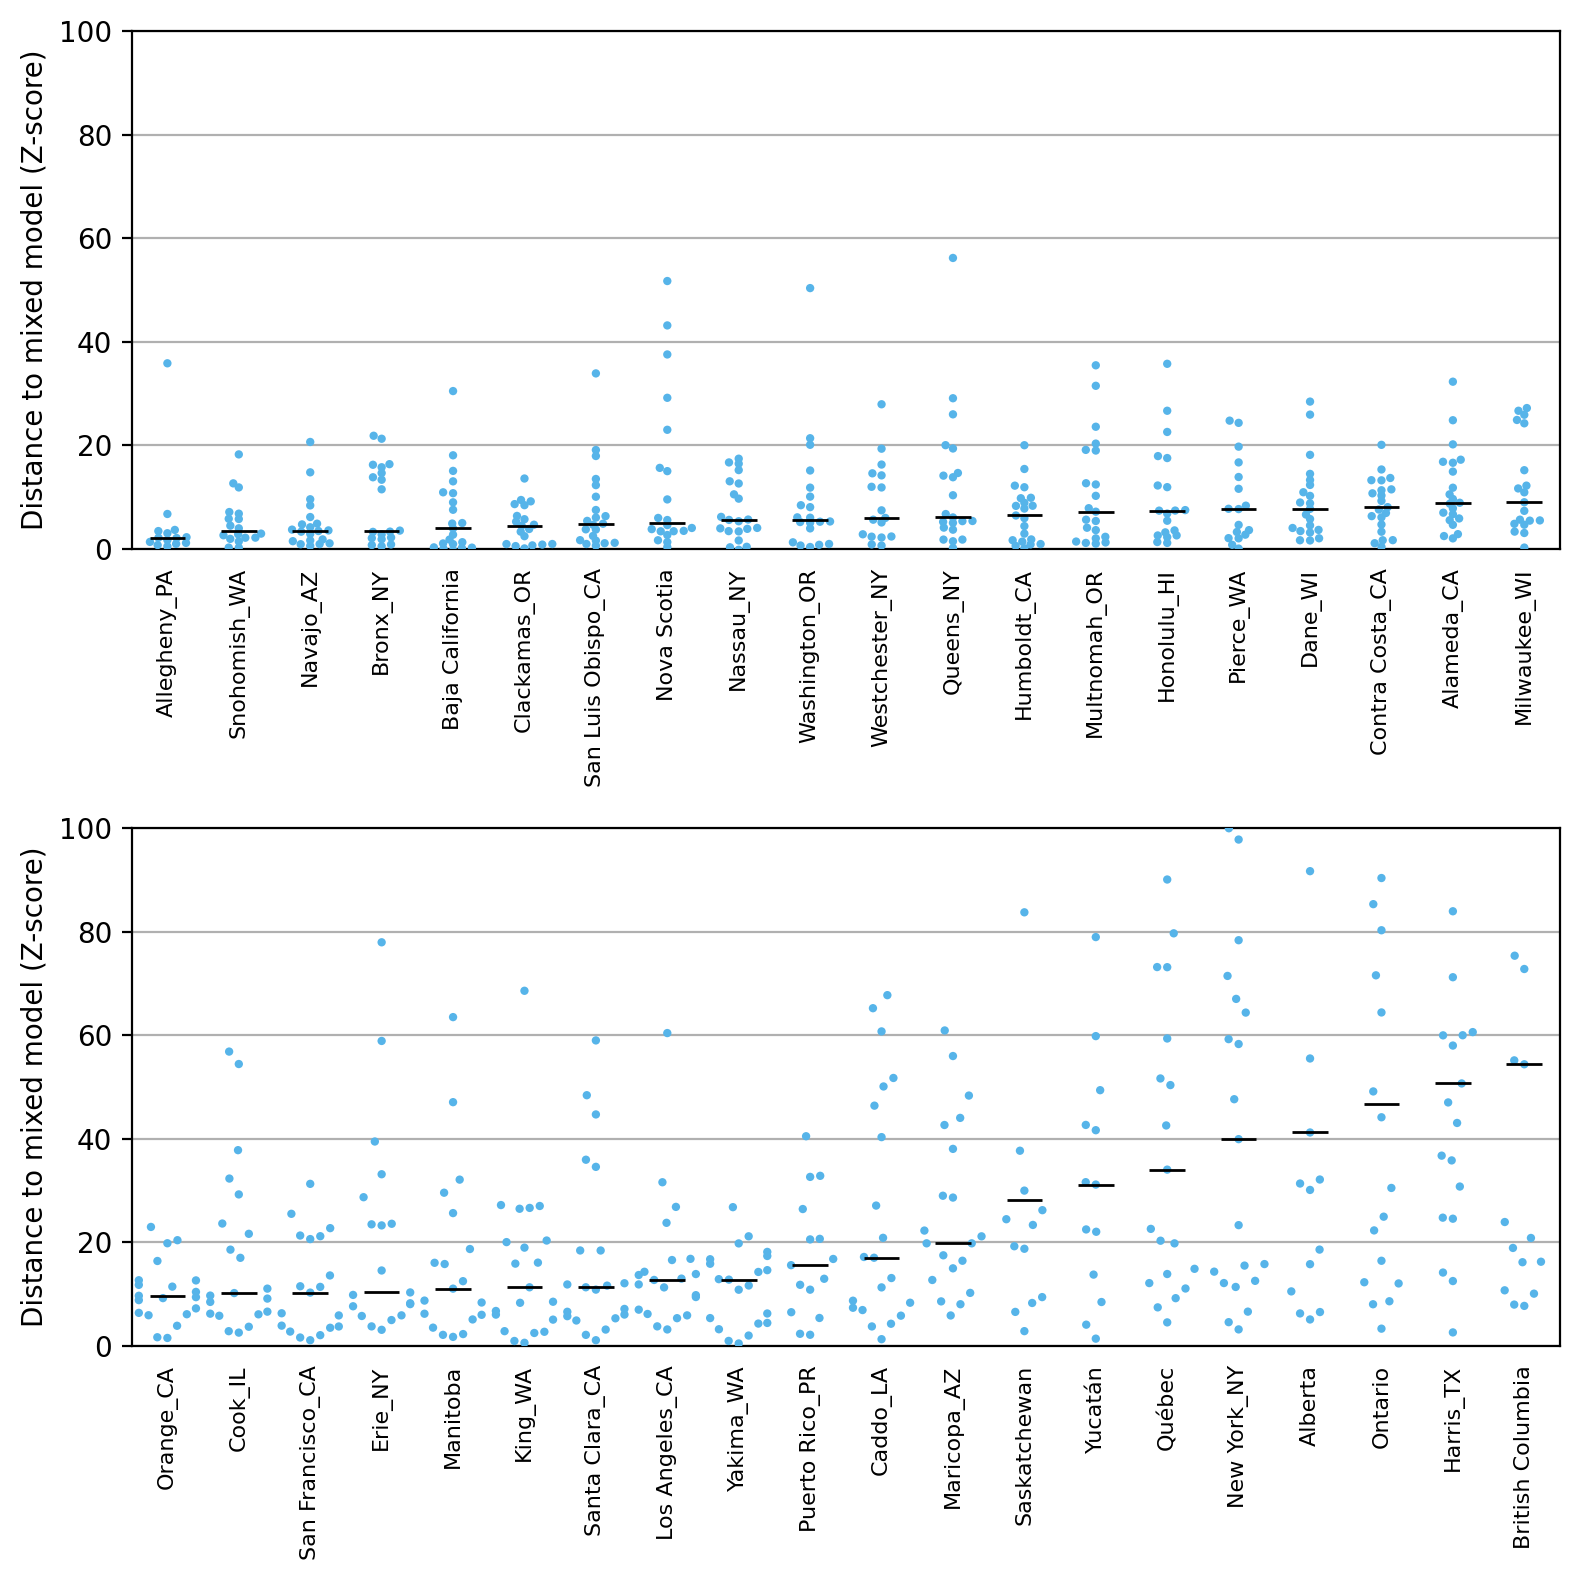

In [99]:
cor = correct_results( hill, "local_similarity" )
cor = cor.pivot( index="siteB", columns="date", values="corrected_z" )
cor = cor.drop(columns=pd.to_datetime( "2021-12-01" ) )
cor = cor.reindex(index=cor.median(axis=1).sort_values( ascending=True ).index)

plot_df = cor.iloc[:20]
plot_mean = plot_df.median( axis=1 ).reset_index().reset_index()
plot_df = plot_df.melt( var_name="date", value_name="value", ignore_index=False ).reset_index()
#
plot_df2 = cor.iloc[20:]
plot_mean2 = plot_df2.median( axis=1 ).reset_index().reset_index()
plot_df2 = plot_df2.melt( var_name="date", value_name="value", ignore_index=False ).reset_index()


fig, ax = plt.subplots( dpi=200, figsize=(8,8), nrows=2, sharey=True )
sns.swarmplot( x="siteB", y="value", data=plot_df, size=3, ax=ax[0], color="#56B4E9" )
sns.swarmplot( x="siteB", y="value", data=plot_df2, size=3, ax=ax[1], color="#56B4E9" )
ax[0].hlines( plot_mean[0], xmin=plot_mean["index"]-0.25, xmax=plot_mean["index"]+0.25, color="black", linewidth=1, zorder=100 )
ax[1].hlines( plot_mean2[0], xmin=plot_mean2["index"]-0.25, xmax=plot_mean2["index"]+0.25, color="black", linewidth=1, zorder=100 )

ax[0].tick_params( axis="x", bottom=False, which="both", rotation=90, labelbottom=True, labelsize=8 )
ax[0].set_ylabel( "Distance to mixed model (Z-score)" )
ax[0].set_xlabel( "" )
#ax[0].set_title( f"Mean normalized PhyloSor" )
ax[0].grid( axis="y", zorder=1 )

ax[1].tick_params( axis="x", bottom=False, which="both", rotation=90, labelbottom=True, labelsize=8 )
ax[1].set_ylabel( "Distance to mixed model (Z-score)" )
ax[1].set_xlabel( "" )
ax[1].grid( axis="y", zorder=1 )
ax[1].set_ylim(0,100)

plt.tight_layout()
#plt.savefig( f"mixed_phylosor_all.pdf" )
plt.show()

In [107]:
# Is there concordence between PhyloSor and Hill

raw = hill.loc[hill["kind"]=="actual1"]
raw = raw.pivot( index="siteB", columns="date", values="local_similarity" )
hill_ranks = raw.median(axis=1).sort_values( ascending=False ).reset_index().reset_index()
hill_ranks.columns = ["hill_rank","siteB", "median_hill"]

raw = res.loc[res["kind"]=="actual1"]
raw = raw.pivot( index="siteB", columns="date", values="value" )
phylosor_ranks = raw.median(axis=1).sort_values( ascending=False ).reset_index().reset_index()
phylosor_ranks.columns = ["phylosor_rank", "siteB", "median_phylosor"]

comparison = hill_ranks.merge( phylosor_ranks )
comparison
#
#from scipy.stats import kendalltau
#kendalltau( hill_ranks, phylosor_ranks )

,hill_rank,siteB,median_hill,phylosor_rank,median_phylosor
0,0,Los Angeles_CA,0.718775,0,0.187425
1,1,Maricopa_AZ,0.699381,1,0.150849
2,2,Baja California,0.676702,5,0.132050
3,3,Puerto Rico_PR,0.675767,22,0.083616
4,4,San Francisco_CA,0.674239,4,0.138371
5,5,Santa Clara_CA,0.660886,2,0.140000
6,6,San Luis Obispo_CA,0.656254,10,0.111111
7,7,Pierce_WA,0.651697,18,0.090213
8,8,Bronx_NY,0.649543,27,0.075500
9,9,Honolulu_HI,0.647571,23,0.083492


<AxesSubplot:xlabel='median_phylosor', ylabel='median_hill'>

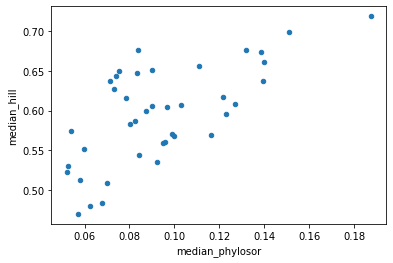

In [110]:
comparison.plot( x="median_phylosor", y="median_hill", kind="scatter" )